### ECG Signals - SPEK

In this notebook we adress the issue of lossy construction from magnitude stft or spectrogram. This is known as the phase recovery problem.

In [2]:
import torch
import torchaudio 
import wfdb
import os
import sys
import wfdb
import numpy as np
import pywt
import random
import string
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing

print('Virtual Environment:')
print(sys.prefix)

Virtual Environment:
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


#### Updated Spectrogram Methods

Since we know there is not a lot of import infromation above 180 hZ , we decide to use the (magnitude) of spectogram up to 180 Hz. This is partly inspired by this parer: https://www.google.com/search?client=firefox-b-d&q=Atrial_Fibrillation_Detection_Using_Deep_Features_.pdf. We could 'pre' downsample the signal (I suppose).. but we keep working with signals at 360 Hz.

Now... a real problem! We lose phase information, which means we will have to work with a lossy reconstruction. Some paper did not clearly mention this by saying... used pytorchaudio and done. There are multiple ways to adress this issue. Some great recources can be found here:

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 

Approach 1:

- Using lossy conversion with Griffin [PytorchAudio]

In [3]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

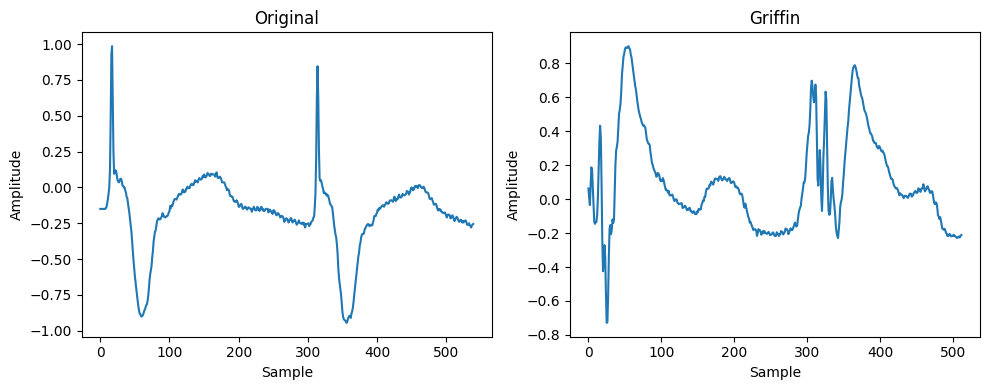

In [9]:
# def ecg_to_spectrogram(ecg_signal):

#     I_tensor = torch.tensor(ecg_signal)
#     # Compute the STFT
#     stft = torch.stft(I_tensor, n_fft=128, center=True, pad_mode='reflect', normalized=True, onesided=True, return_complex=True)
#     magnitude = torch.abs(stft)

#     log_magnitude = 10 * torch.log10(magnitude)
 
#     return log_magnitude


def ecg_to_spectrogram(ecg_signal, n_fft=128, hop_length=None):
    """
    Convert ECG signal to spectrogram using torchaudio library.

    Args:
    - ecg_signal (torch.Tensor): 1D tensor representing the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Spectrogram of the ECG signal.
    """
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=None)(ecg_signal)

    return spectrogram

def spectrogram_to_ecg(spectrogram, n_fft=128, hop_length=None):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=128,  n_iter=50000, hop_length=None)(spectrogram)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal

# Path to individual ecg file
path_102 = "data/ardb/104"

# Extract record
record_102 = wfdb.rdsamp(path_102, sampto=540)

# Extract Lead I ECG signal
signal_102 = record_102[0][:, 0]

sig = torch.tensor(signal_102)
spek = ecg_to_spectrogram(sig)
# visualize_spectrogram(spek)
reconstructed_sig = spectrogram_to_ecg(spek)

plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin'])

#  TODO:
#  - add a method.. visualize spectrogram

Great looking spectrogram from scratch...

In [3]:
import torch
from torchaudio import transforms
from torchaudio.functional import inverse_spectrogram


def ecg_to_spectrogram(ecg_signal):

    I_tensor = torch.tensor(ecg_signal)
    # Compute the STFT
    stft = torch.stft(I_tensor, n_fft=128, center=True, pad_mode='reflect', normalized=True, onesided=True, return_complex=True)
    magnitude = torch.abs(stft)

    log_magnitude = 10 * torch.log10(magnitude)
 
    return log_magnitude


# Define spectrogram_to_ecg function
def spectrogram_to_signal(spectrogram):
    magnitude = 10 ** ((spectrogram / 20))  # Convert back to magnitude
    phase = np.random.rand(*magnitude.shape) * 2 * np.pi  # Random phase
    stft_complex = magnitude * np.exp(1j * phase)  # Combine magnitude and phase
    signal = torch.istft(torch.tensor(stft_complex), n_fft=128, center=True, normalized=True, onesided=True, return_complex=False)
    return signal.numpy()

def visualize_spectrogram(spectrogram):
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='jet')
    plt.xlabel('Time')
    plt.ylabel('Frequency Bin')
    plt.title('Spectrogram')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()


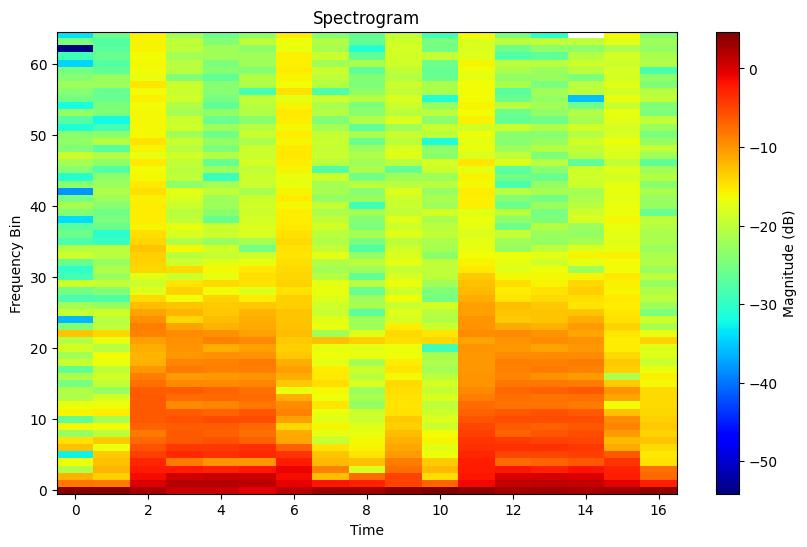

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram  # Import the Hanning window function
import wfdb

record_104 = wfdb.rdsamp("data/ardb/102",sampto=540)
signal_104 = record_104[0][:, 0]

spek = ecg_to_spectrogram(signal_104)

visualize_spectrogram(spek)


# visualize_spectrogram(spek[:2])

#  = spectrogram_to_signal(spek)

# plot_multiple_timeseries([signal_104, sig], ['Original', 'Reconstructed'])




These are our new methods, for 'better' spectrograms...

- The new methods

#### Additional Datasets

Assume we want to obtain a bigger dataset... We can additionaly also process the (filtered) data in the ECG-ID dataset: https://physionet.org/content/ecgiddb/1.0.0/ --- However... the samples contain cleaned parts... but are said that the quality is not too great... and sampling frequency 500.

Hold up...
- We can use the real noisy samples here... As 'real' data!

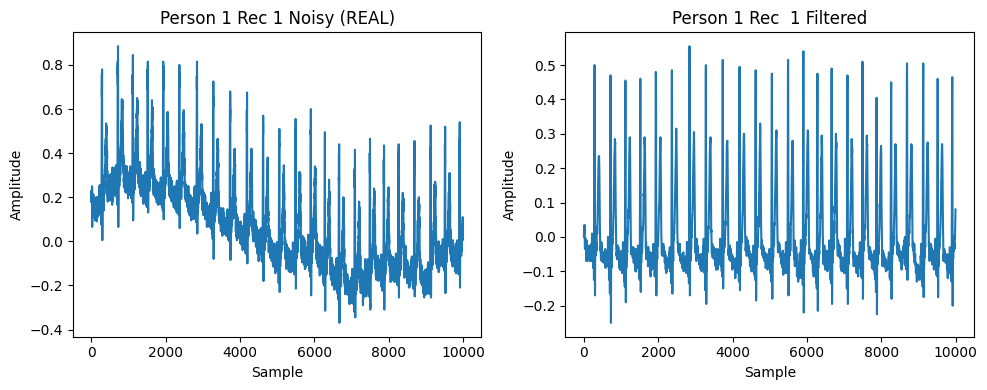

In [ ]:
record_id_p1_rec_1 = wfdb.rdsamp("data/ecg-id-database/Person_63/rec_1")
signal_id_p1_rec_1_noisy = record_id_p1_rec_1[0][:, 0]
signal_id_p1_rec_1_filtered = record_id_p1_rec_1[0][:, 1]

plot_multiple_timeseries([signal_id_p1_rec_1_noisy, signal_id_p1_rec_1_filtered], ['Person 1 Rec 1 Noisy (REAL)', 'Person 1 Rec  1 Filtered'])            # Nice...

Another popular dataset would be: https://physionet.org/content/ptb-xl/1.0.3/ which  was downloaded here at https://www.kaggle.com/datasets/bjoernjostein/ptbxl-electrocardiography-database. We use lead I from this data, and resample to 360 to match our previous data. Might cause some aliasing... Not sure how much this matters.

In [ ]:
%pip install resampy

Note: you may need to restart the kernel to use updated packages.


Length of HR1 5000
Length of HR1 Resample Scipy 3600


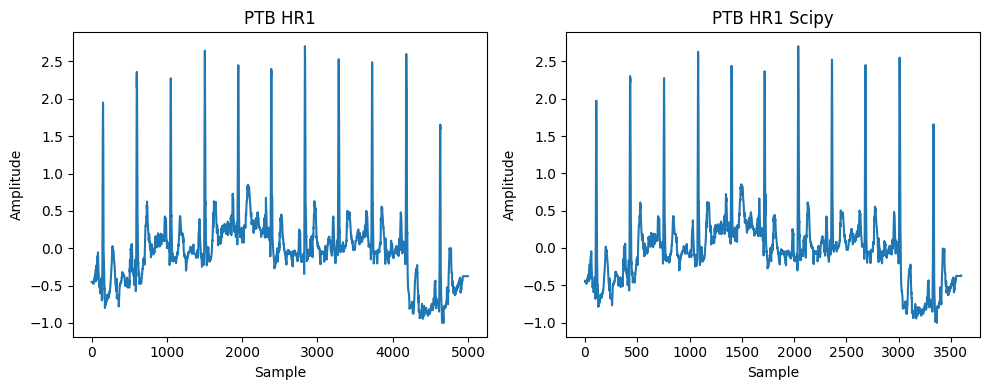

In [ ]:
from scipy.signal import resample

record_ptb_HR1 = wfdb.rdsamp("data/PTB-XL/HR10303")
signal_ptb_HR1 =  record_ptb_HR1[0][:, 0]

# Original sampling rate
original_sampling_rate = 500  # Hz

# Target sampling rate
target_sampling_rate = 360  # Hz

# Resample the signal
num_samples_target = int(len(signal_ptb_HR1) * target_sampling_rate / original_sampling_rate)
resampled_signal_ptb_HR1 = resample(signal_ptb_HR1, num_samples_target)


print('Length of HR1', len(signal_ptb_HR1))
print('Length of HR1 Resample Scipy', len(resampled_signal_ptb_HR1))

plot_multiple_timeseries([signal_ptb_HR1, resampled_signal_ptb_HR1], ['PTB HR1','PTB HR1 Scipy'])

Let us first investigate the model for 57k samples... See how long the training takes.

#### Generative Models: Difffusion Models (and Latent Flow)

Since we like to do something that is somehow original, we can take inspiration from papers that worked with diffusion models for example to generate ECG signals or that use conditional diffusion, but take a slightly different approach. If we feel comfortable, we can look into latent flow model and probably be the first to try this out! Since many papers said there are downsides with GANs, we avoid these. 

We switch to the **src** folder for now and start adapting the SR3 model that is used for super resolution: https://arxiv.org/pdf/2104.07636.pdf.